# SDLE - Sistemas Distribuídos em Larga Escala
## Trabalho prático - *Flow updating*

In [ ]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import heapq as hq
from numpy import arange

Geração de grafos conectados.

In [ ]:
def connectedGraph(nVertices):
    # Initialize the graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(nVertices))

    # List all possible edges
    edges = list(nx.non_edges(G))
    random.shuffle(edges)
    while not nx.is_connected(G):
        x, y = edges.pop()
        G.add_edge(x, y)

    return G

Exibição gráfica do grafo gerado.

In [ ]:
def drawGraph(G):
    plt.figure(figsize = (16,8), dpi = 200)
    nx.draw_networkx(G,
                     with_labels = True,
                     style = "solid",
                     node_size = 700,
                     node_color = "orange",
                     font_size = 14,
                     font_color = "black",
                     font_weight = "bold")
    plt.show()

Classe relativa à versão ***broadcast*** do algoritmo escolhido, isto é, ***flow updating*** :

In [ ]:
class FlowUpdatingBroadcast:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue
        
    def changeNeighbors(self, newNeighbors):
        newF, newE = {}, {}
            
        for n in newNeighbors:
            if n in self.neighbors:
                newF[n] = self.f[n]
                newE[n] = self.e[n]
            else:
                newF[n] = 0
                newE[n] = 0

        self.neighbors, self.f, self.e = newNeighbors, newF, newE

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        for n in self.neighbors:
            msg = (self.f[n], self.e[n])
            messages.append(("FLOW", (n, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e
            
        self.messages = []

        newE = self.calculateEstimate()

        for n in self.neighbors:
            self.f[n] += newE - self.e[n]
            self.e[n] = newE

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                self.state_transition()
                return self.gen_message()
        return []

Classe relativa à versão ***unicast*** do algoritmo escolhido, isto é, ***flow updating*** :

In [ ]:
class FlowUpdatingUnicast:
    def __init__(self, neighbors, inputValue, timeout):
        self.timeout = timeout
        self.messages = []
        self.neighbors = neighbors
        self.f = {}
        self.e = {}
        self.k = self.chooseNeighbor()
        for n in neighbors:
            self.f[n] = 0
            self.e[n] = 0
        self.v = inputValue

    def changeNeighbors(self, newNeighbors):
        newF, newE = {}, {}
            
        for n in newNeighbors:
            if n in self.neighbors:
                newF[n] = self.f[n]
                newE[n] = self.e[n]
            else:
                newF[n] = 0
                newE[n] = 0

        self.neighbors, self.f, self.e = newNeighbors, newF, newE
        
    def chooseNeighbor(self):
        return random.choice(list(self.neighbors))

    def gen_message(self):
        messages = [("TIMEOUT", self.timeout, True)]
        msg = (self.f[self.k], self.e[self.k])
        messages.append(("FLOW", (self.k, msg)))
        return messages

    def calculateEstimate(self):
        sumF = 0
        sumE = 0
        for n in self.neighbors:
            sumF += self.f[n]
            sumE += self.e[n]
        return (self.v - sumF + sumE) / (len(self.neighbors) + 1)

    def state_transition(self):
        for m in self.messages:
            src = m[0]
            (f, e) = m[1]
            self.f[src] = -f
            self.e[src] = e
            
        self.messages = []

        newE = self.calculateEstimate()

        self.k = self.chooseNeighbor()
        
        self.f[self.k] += newE - self.e[self.k]
        self.e[self.k] = newE

    def handle(self, src, msg):
        if msg == "INITIAL":
            return self.gen_message()
        else:
            if msg[0] == "FLOW":
                self.messages.append((src, msg[1]))
            else: # timeout message, end of round
                self.state_transition()
                return self.gen_message()
        return []

Classe *Simulator* :

In [ ]:
class Simulator:
    def __init__(self, nodes, distances, faultProbability, viewChange, timeout):
        self.nodes = nodes
        self.distances = distances
        self.currentTime = 0
        self.pending = [] # [(delay, (src, dest, msg))]
        self.faultProbability = faultProbability
        self.viewChange = viewChange
        self.timeout = timeout

    def closeToTarget(self, target):
        currentEstimate, numEstimates = 0, 0
        for n in self.nodes.values():
            est = n.e.values()
            currentEstimate += sum(est)
            numEstimates += len(est)
        currentEstimate /= numEstimates

        # print("----- ", target, currentEstimate)
        
        if abs(round(target, 3) - round(currentEstimate, 3)) <= 0.01:
            return True
        return False

    def start(self):
        # Calculate target value
        target = 0
        for node in self.nodes.values():
            target += node.v
        target /= len(self.nodes)

        # Generate initial messages
        for n in self.nodes:
            event = (0, (None, n, "INITIAL"))
            hq.heappush(self.pending, event)

        # Add first view change
        if self.viewChange != -1:
            hq.heappush(self.pending, (self.viewChange, (float("+infinity"), None, "VIEWCHANGE")))

        return self.runLoop(target)

    def runLoop(self, target):
        sent_messages = len(self.pending)
        while len(self.pending) != 0:
            if self.closeToTarget(target):
                break
            
            if len(self.pending) == 1:
                (delay, (src, dest, msg)) = self.pending[0]
                if msg != "VIEWCHANGE":
                    break

            (delay, (src, dest, msg)) = hq.heappop(self.pending)
            # print(dest, "received", msg, "from", src, "at", delay)
            self.currentTime = delay

            # Message to change the view
            if msg == "VIEWCHANGE":
                # print("View changing ...")

                vc = (self.currentTime + self.viewChange, (float("+infinity"), None, "VIEWCHANGE"))
                # print("VIEWCHANGE", vc)
                hq.heappush(self.pending, vc)

                newGraph = connectedGraph(len(self.nodes))
                drawGraph(newGraph)
                self.distances, self.nodes = newNeighborsAndDistances(newGraph, self.nodes, False, self.timeout)
                continue

            # Message between two nodes or a timeout
            newEvents = self.nodes[dest].handle(src, msg)

            if newEvents:
                #sent_messages += len(newEvents)
                for x in newEvents:
                    if x[0] != "TIMEOUT":
                        flag = False
                        sent_messages += 1
                        (msgType, (newMsgDest, newMsg)) = x
                        if self.faultProbability != 0 and random.randrange(round(1/self.faultProbability)) == 0: # fault-injection mechanism
                            # print("Dropped", newMsg, "from", dest, "to", newMsgDest)
                            continue
                        dist = 0
                        if (dest, newMsgDest) not in self.distances and (newMsgDest, dest) not in self.distances:
                            # print("Dropped one message from", dest, "to", newMsgDest, "because they are no longer neighbors")
                            continue
                        if dest < newMsgDest:
                            dist = self.distances[(dest, newMsgDest)]
                        else:
                            dist = self.distances[(newMsgDest, dest)]

                        ev = (self.currentTime + dist, (dest, newMsgDest, (msgType, newMsg)))
                        hq.heappush(self.pending, ev)
                    else:
                        (msgType, timeout, newMsg) = x
                        ev = (self.currentTime + timeout, (dest, dest, (msgType, timeout, newMsg)))
                        hq.heappush(self.pending, ev)

        return sent_messages, (self.currentTime / self.timeout)

Função que determina os pesos das arestas do grafo gerado, instanciando o algoritmo em causa :

In [ ]:
def newNeighborsAndDistances(G, nodes, version, timeout):
    distances = {}
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        if version == "Broadcast":
            nodes[node] = FlowUpdatingBroadcast(neighbors, random.randrange(100), timeout)
        elif version == "Unicast":
            nodes[node] = FlowUpdatingUnicast(neighbors, random.randrange(100), timeout)
        else:
            nodes[node].changeNeighbors(neighbors)

        for neighbor in neighbors:
            if node < neighbor:
                distances[(node, neighbor)] = 1
            else:
                distances[(neighbor, node)] = 1

    return distances, nodes

Exibição dos gráficos referentes à análise do algoritmo *flow updating* :

In [ ]:
def showPlot(x, yBroadcast, yUnicast, labelBroadcast, labelUnicast, xlabel, ylabel):
    plt.figure(figsize = (16,8), dpi = 200)
    plt.title("$\it{Flow}$ $\it{Updating}$ - $\it{Broadcast}$ $\it{vs}$ $\it{Unicast}$")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lineBroadcast, = plt.plot(x, yBroadcast, label = labelBroadcast)
    lineUnicast,   = plt.plot(x, yUnicast, label = labelUnicast)
    
    plt.legend(handles = [lineBroadcast, lineUnicast], loc = "upper left")
    plt.show()

Função relativa ao arranque do algoritmo :

In [ ]:
def main(G, version, fp, vcp):
    N = 5 # number of rounds
    timeout = 2
    
    messages_sent = 0
    rounds = 0
    
    for i in range(N):
        distances, nodes = newNeighborsAndDistances(G, {}, version, timeout)

        sim = Simulator(nodes, distances, fp, vcp, timeout)
        x, y = sim.start()
        messages_sent += x
        rounds += y
    
    return float(rounds / N), float(messages_sent / N)

Função responsável por realizar os testes sobre o algoritmo :

In [105]:
"""
    fp  --> fault-probability       : probability for a message to be lost
    vcp --> view-change periodicity : every "vcp" seconds, the set of neighbors change
"""
def test():
    # Case nº 1 -----------------------------------------------------------------------------------------------------------------------------------------------
    messagesBroadcast, messagesUnicast, roundsBroadcast, roundsUnicast = [], [], [], []
    nNodes = range(10, 201, 10)
    
    for n in nNodes:
        G = connectedGraph(n)
        fp = 0
        vcp = -1
        
        averageRounds, averageMessages = main(G, "Broadcast", fp, vcp)
        messagesBroadcast.append(averageMessages)
        roundsBroadcast.append(averageRounds)
        
        averageRounds, averageMessages = main(G, "Unicast", fp, vcp)
        messagesUnicast.append(averageMessages)
        roundsUnicast.append(averageRounds)
    
    # Plot nº 1:
    showPlot(nNodes, roundsBroadcast, roundsUnicast, "Broadcast's rounds", "Unicast's rounds", "Number of graph's nodes", "Average number of rounds")
    # Plot nº 2:
    showPlot(nNodes, messagesBroadcast, messagesUnicast, "Broadcast's messages", "Unicast's messages", "Number of graph's nodes", "Average number of messages")

    # Case nº 2 -----------------------------------------------------------------------------------------------------------------------------------------------
    messagesBroadcast, messagesUnicast, roundsBroadcast, roundsUnicast = [], [], [], []
    G = connectedGraph(100)
    fps = list(arange(0, 0.51, 0.1))
    vcp = -1
    
    for fp in fps:
        averageRounds, averageMessages = main(G, "Broadcast", fp, vcp)
        messagesBroadcast.append(averageMessages)
        roundsBroadcast.append(averageRounds)
        
        averageRounds, averageMessages = main(G, "Unicast", fp, vcp)
        messagesUnicast.append(averageMessages)
        roundsUnicast.append(averageRounds)
        
    # Plot nº 3:
    showPlot(fps, roundsBroadcast, roundsUnicast, "Broadcast's rounds", "Unicast's rounds", "Fault probability", "Average number of rounds")
    # Plot nº 4:
    showPlot(fps, messagesBroadcast, messagesUnicast, "Broadcast's messages", "Unicast's messages", "Fault probability", "Average number of messages")

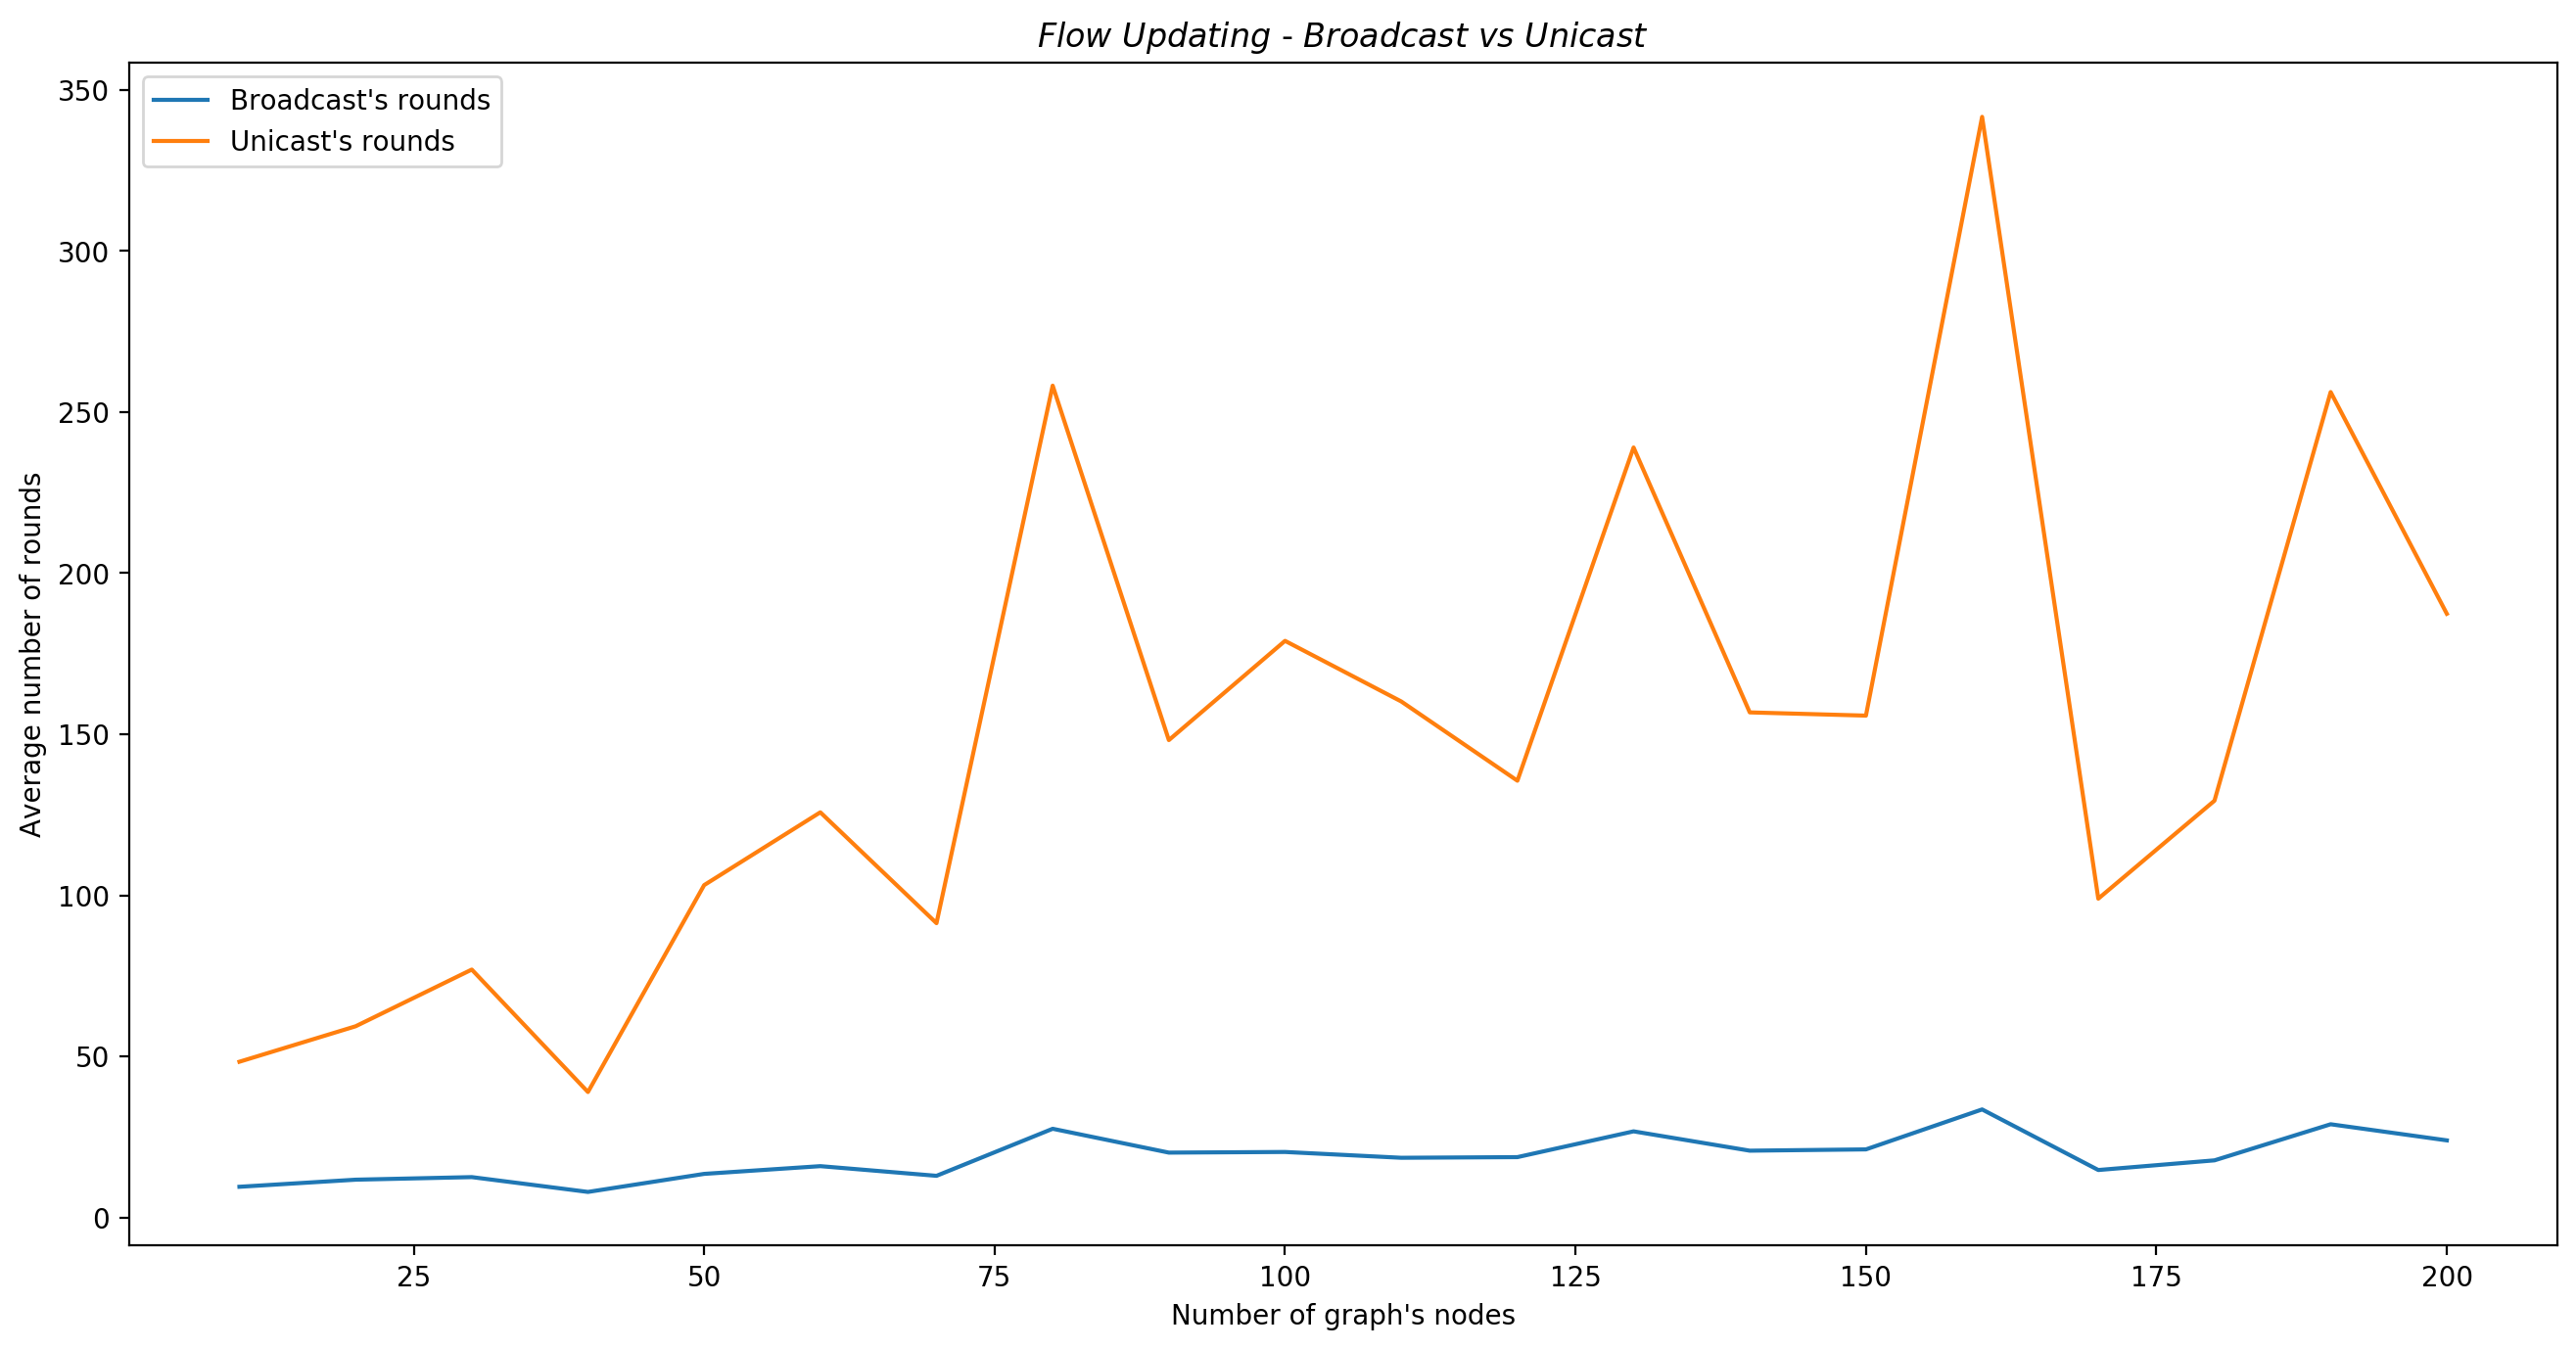

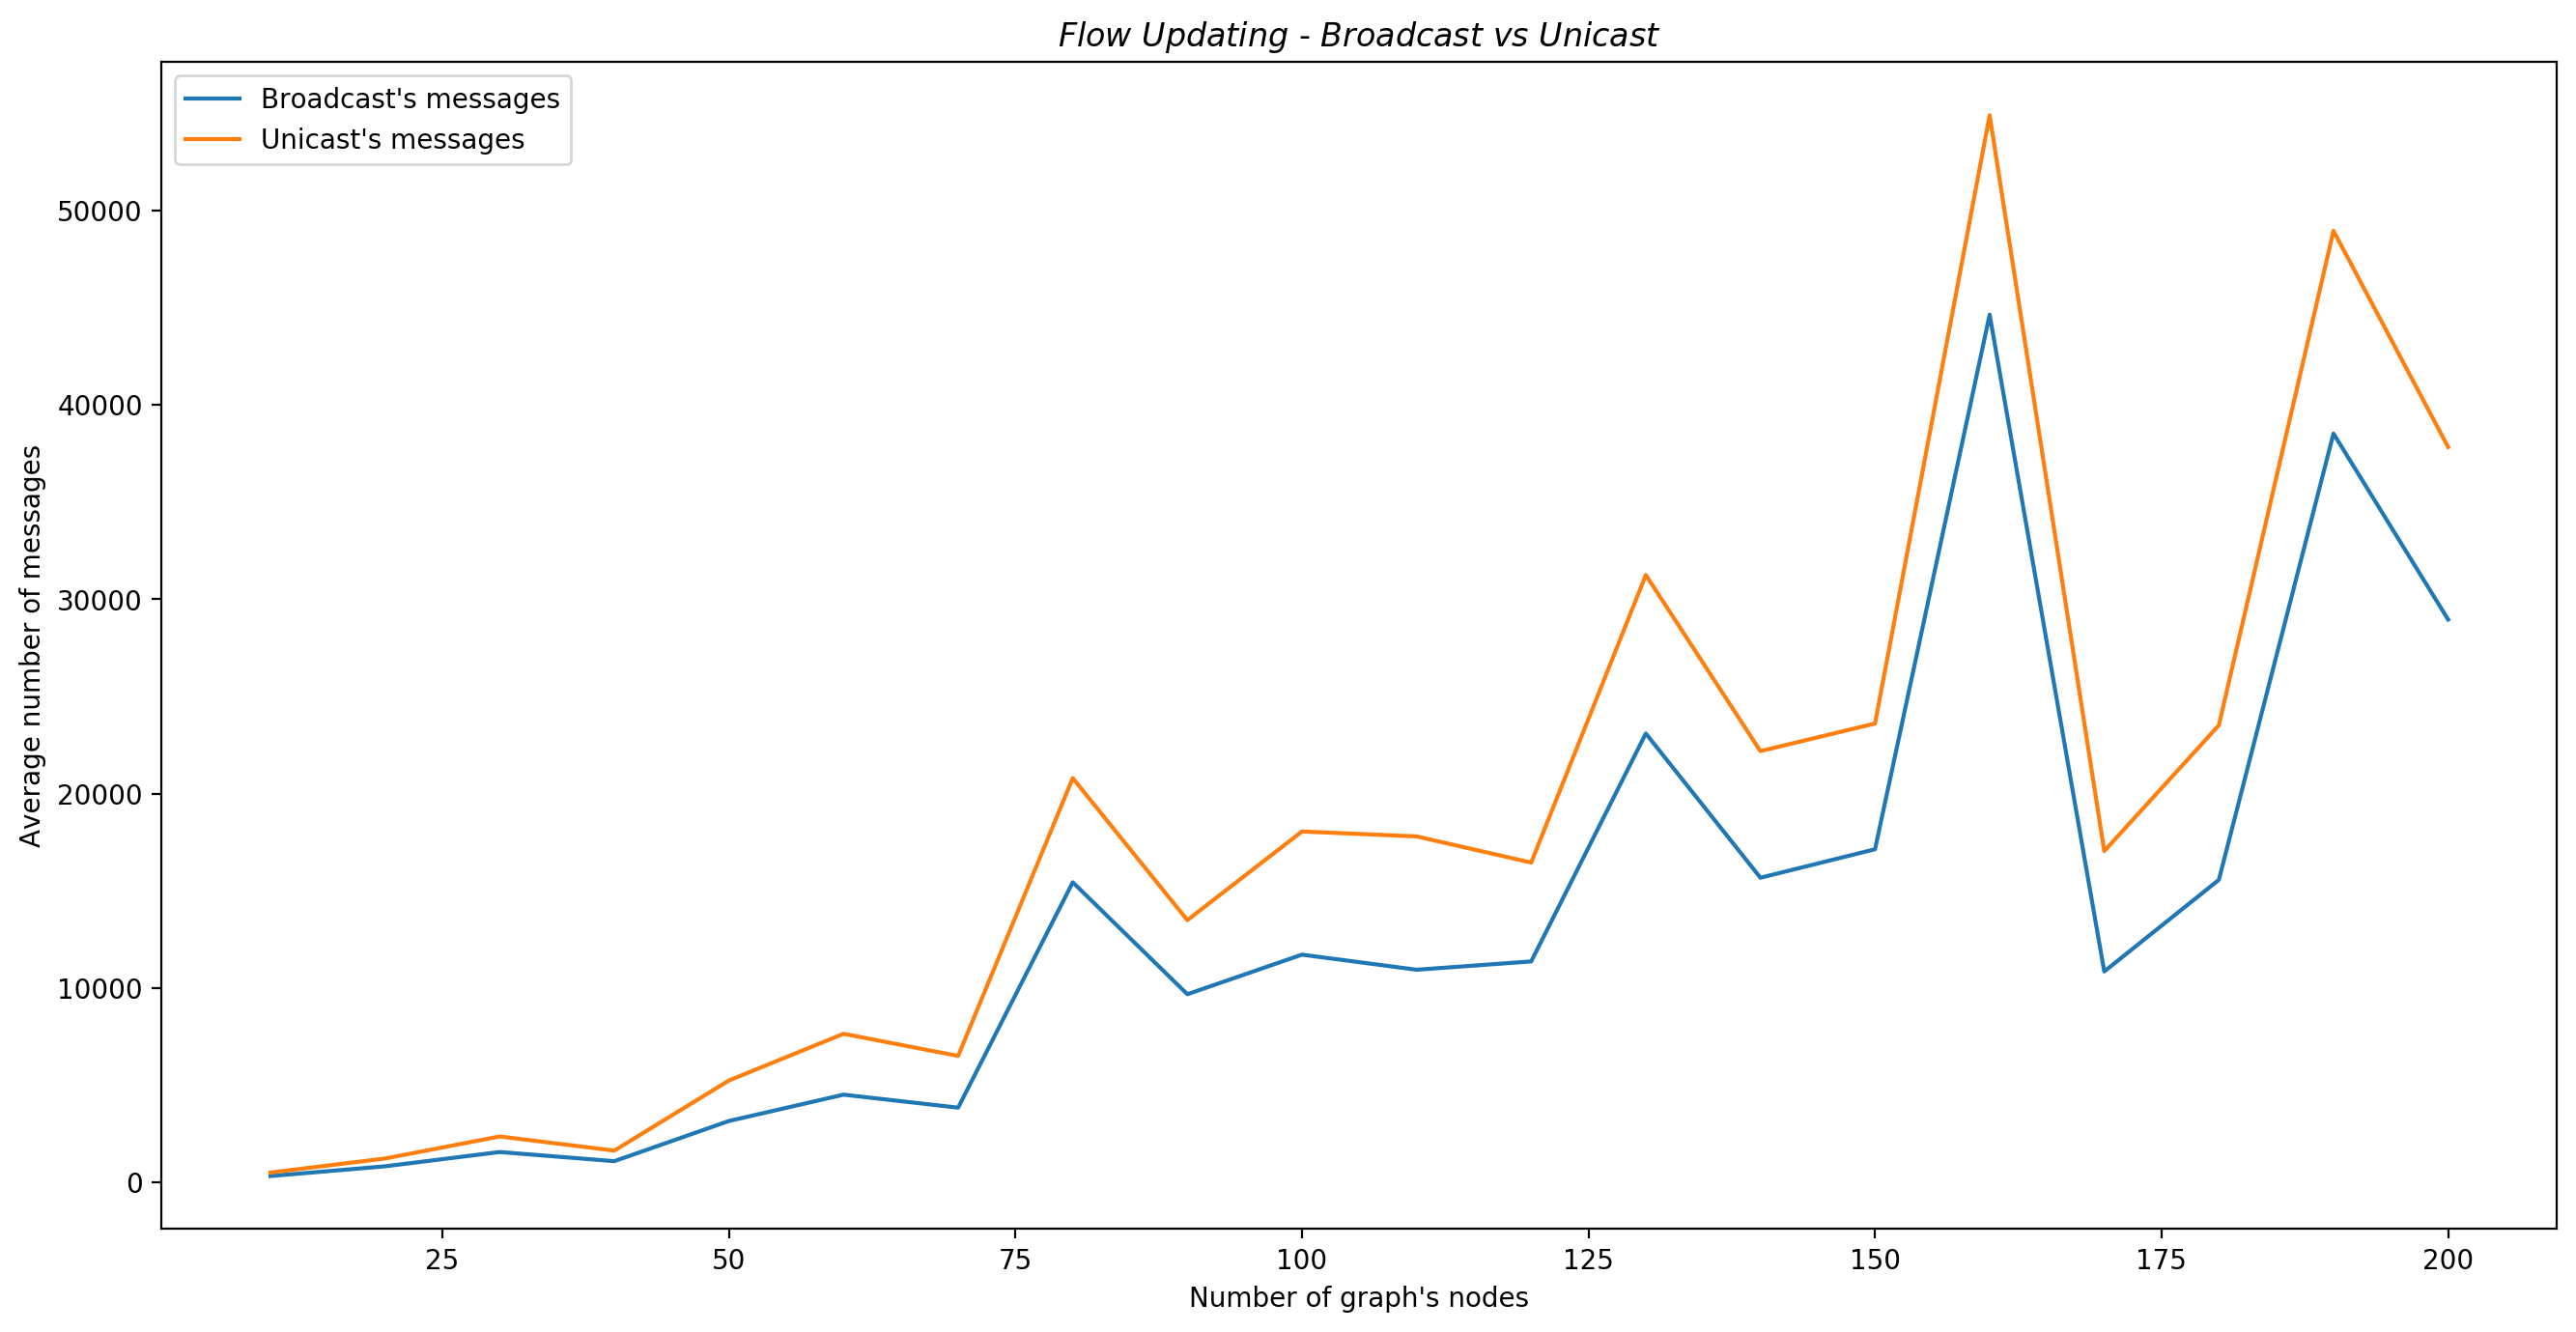

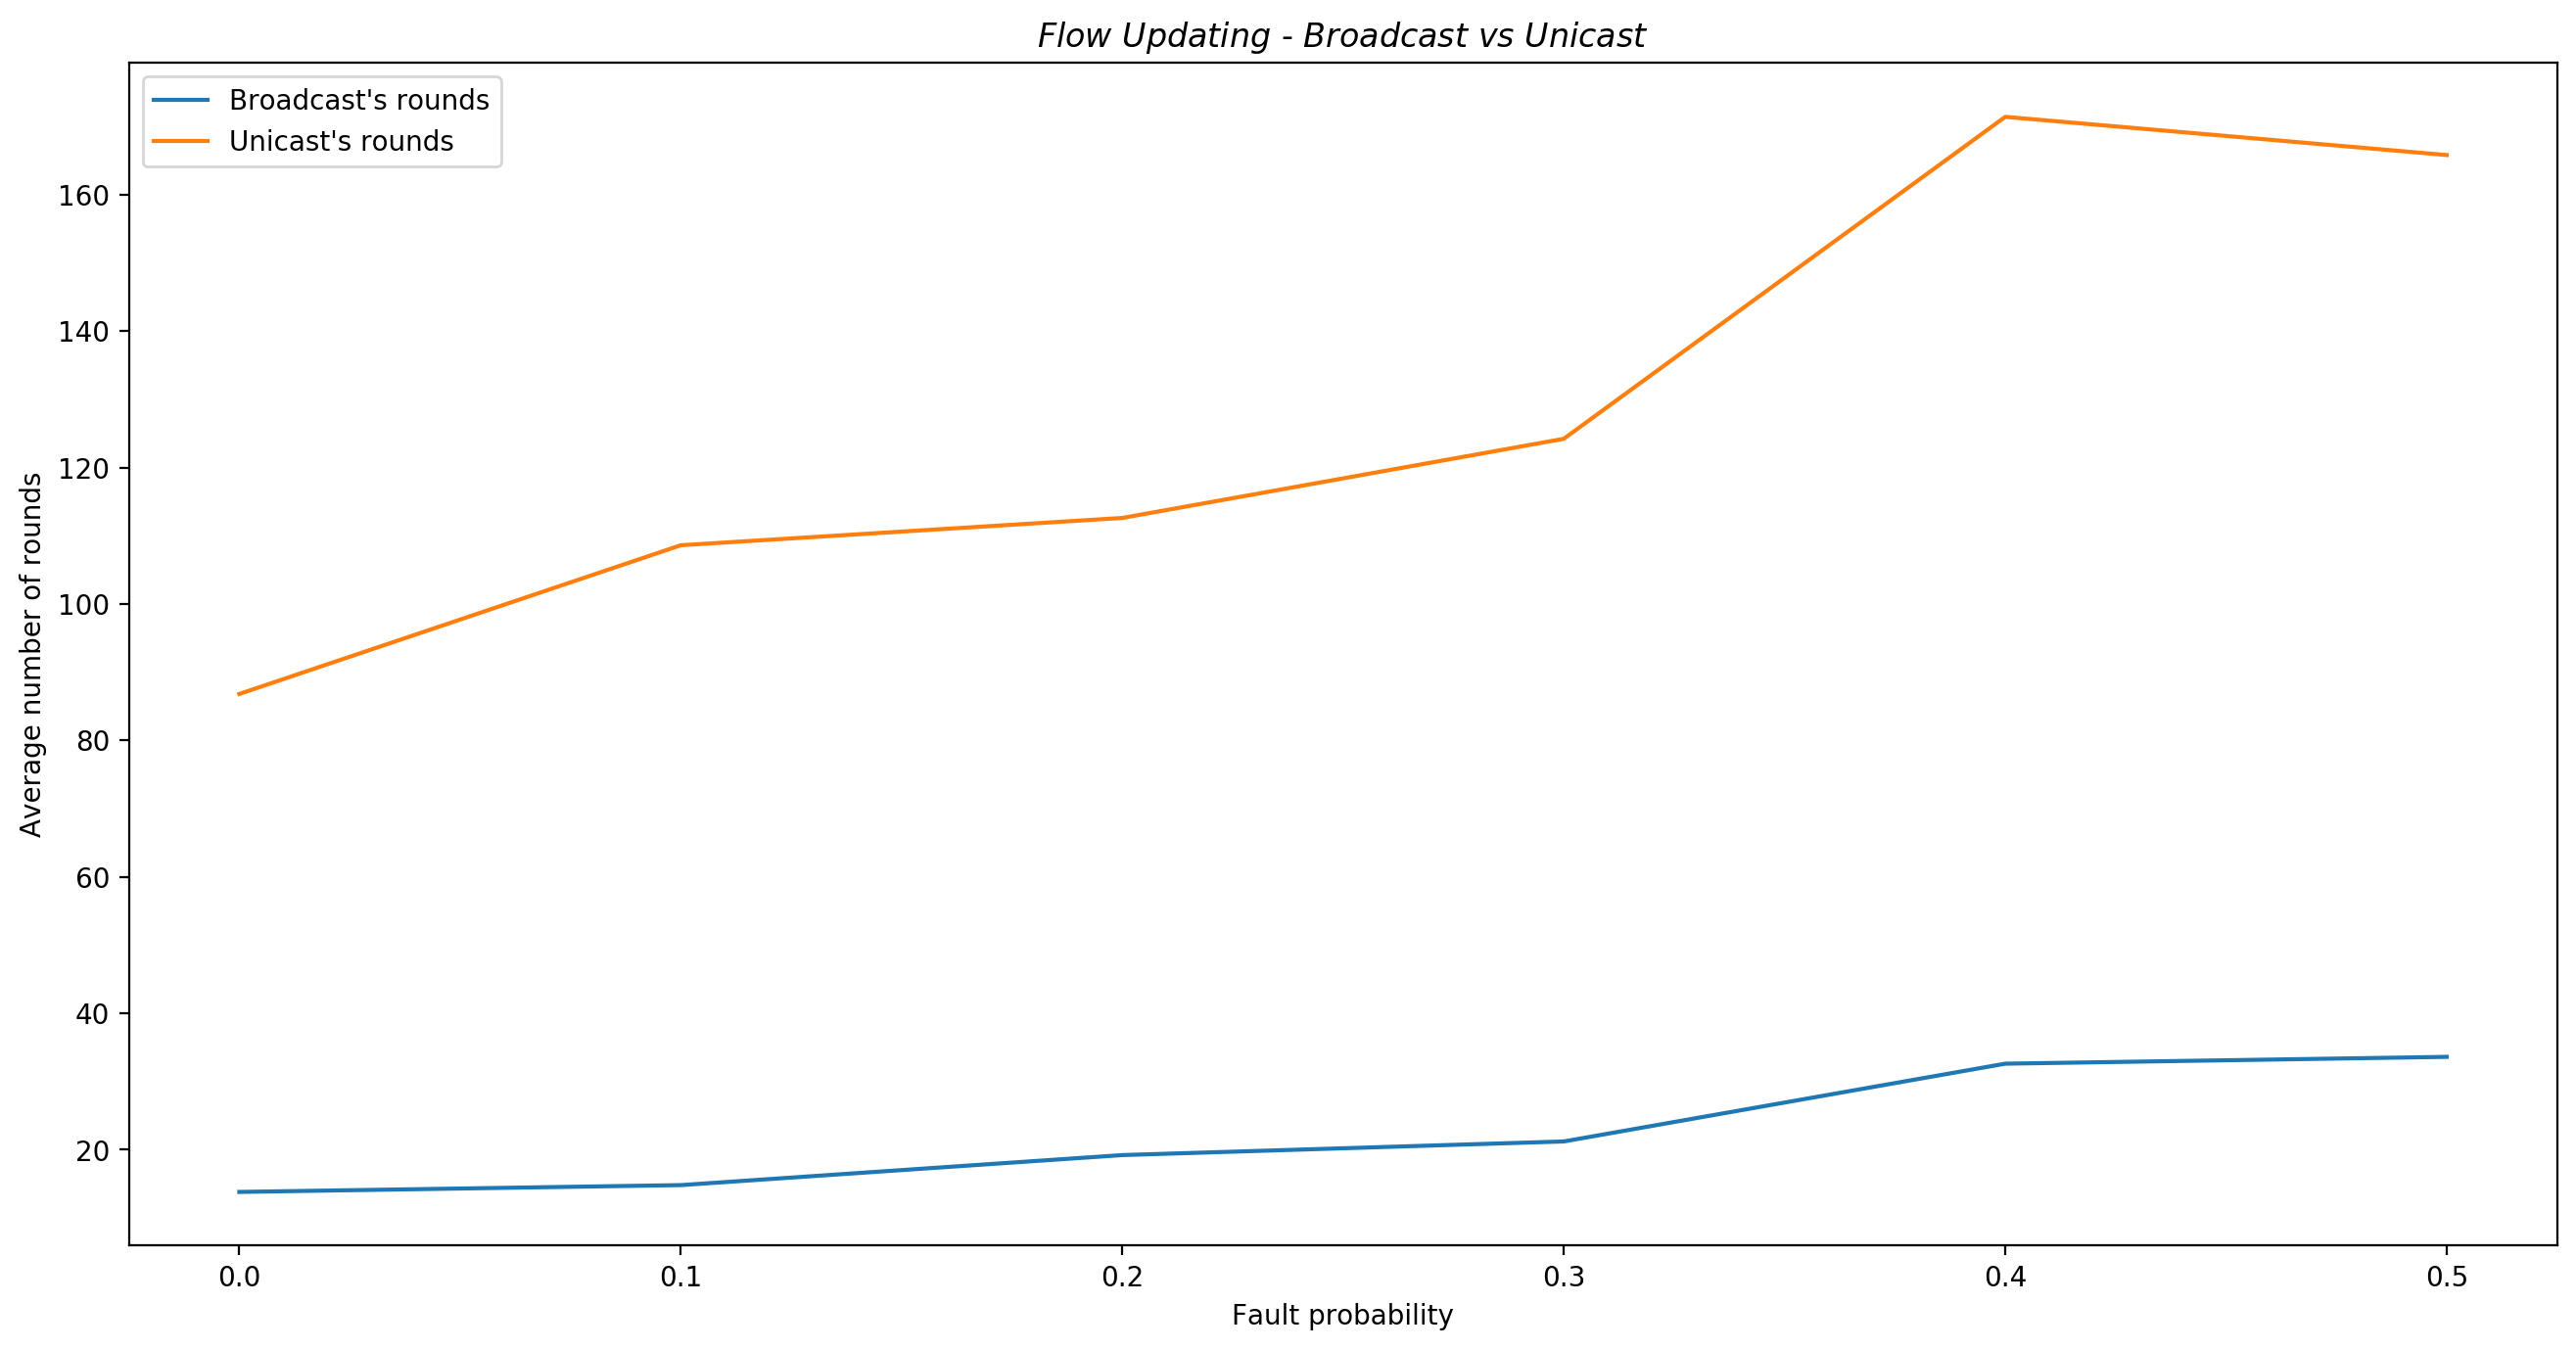

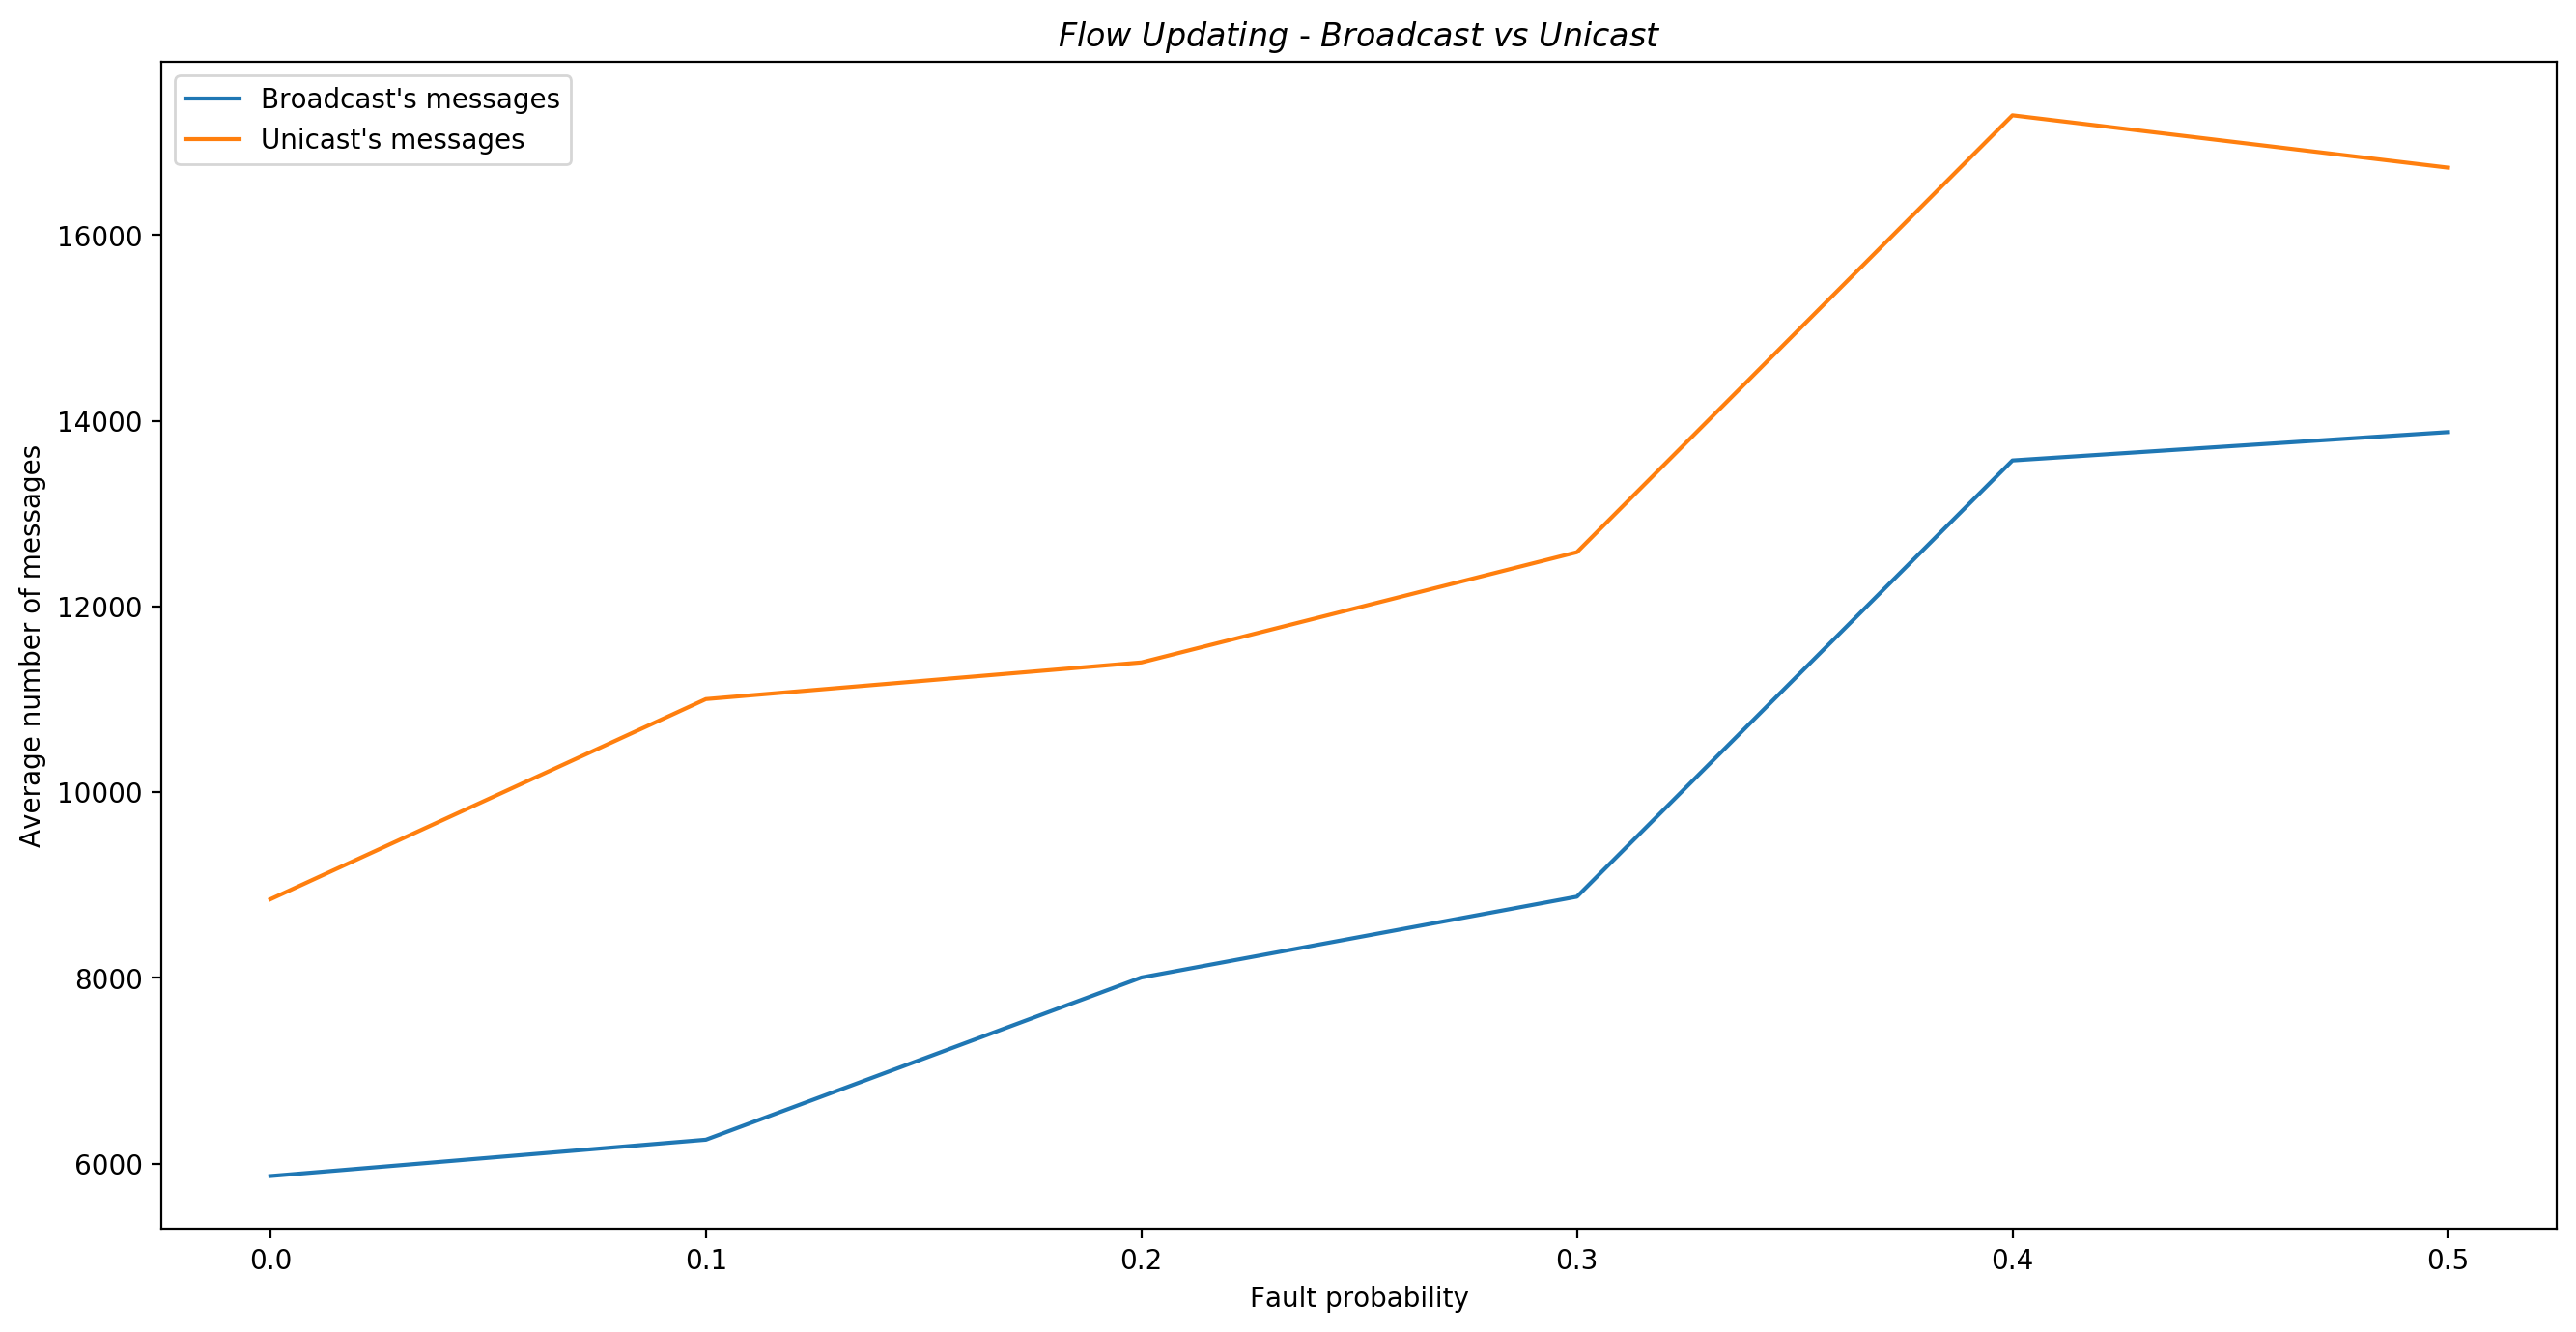

In [106]:
test()